### **1. Importing necessary libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from utils.utils import split_data

from crack_segmentation.subroutines.loss_metrics import (
    Weighted_Cross_Entropy,
    F1_score,
    Precision_dil,
    F1_score_dil
)

### **2. Loading the dataset**

In [18]:
dataset = pd.read_csv('../dataset/dataset_final.csv')

dataset['Filepath'] = dataset['Filepath'].apply(lambda x: "../" + x)

train_df, test_df = train_test_split(
    dataset.sample(6000, random_state=42),
    train_size=0.80,
    random_state=42
)

train_data, valid_data, test_data = split_data(train_df, test_df, image_width=224, image_height=224, class_mode='categorical')

Found 3840 validated image filenames belonging to 2 classes.
Found 960 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


### **3. Segmentation and classification model**

#### **3.1. Importing the model**

In [2]:
model = tf.keras.models.load_model(
    'crack_segmentation/output/checkpoints/final_model_2.h5',
    custom_objects={
        'loss': Weighted_Cross_Entropy(10),
        'F1_score': F1_score,
        'F1_score_dil': F1_score_dil,
        'Precision_dil': Precision_dil
    }
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 225, 225, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                          

#### **3.2. Model evaluate**

In [20]:
loss, acc = model.evaluate(test_data)

print(f'Perda: {loss}')
print(f'Acurácia: {acc}')

38/38 [==============================] - 508s 13s/step - loss: 2.9162 - accuracy: 0.9742
Perda: 2.9161760807037354
Acurácia: 0.9741666913032532


#### **3.3. Making predictions**

In [21]:
y_pred = model.predict(test_data)

38/38 [==============================] - 491s 13s/step


In [22]:
y_pred_labels = np.argmax(y_pred, axis=-1)
cr = classification_report(test_data.labels, y_pred_labels)

print(cr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       576
           1       1.00      0.95      0.97       624

    accuracy                           0.97      1200
   macro avg       0.97      0.98      0.97      1200
weighted avg       0.98      0.97      0.97      1200



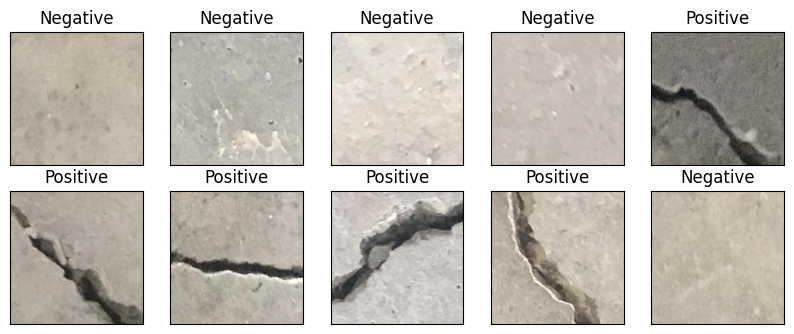

In [23]:
class_names = ['Negative', 'Positive']
fig = plt.figure(figsize=(10,10))

for i in range(10):
    ax = fig.add_subplot(5,5, i + 1, xticks=[], yticks=[])
    ax.imshow(test_data[0][0][i])
    x = class_names[np.argmax(y_pred[i])]
    ax.set_title("{}".format(x))

1/1 [==============================] - 1s 545ms/step


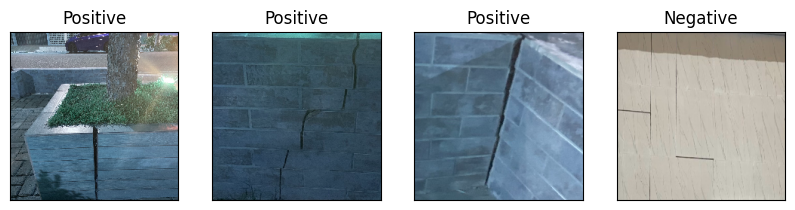

In [6]:
fig = plt.figure(figsize=(10,10))

for x in range(4):
    img_path = cv2.imread(f"crack_segmentation/notebook/images/amostra{x + 1}.jpg")
    img_path = cv2.resize(img_path, (224,224))
    img = np.expand_dims(img_path, axis=0)
    img = img / 255.0
    
    ax = fig.add_subplot(1, 4, x + 1, xticks=[], yticks=[])
    pred = model.predict(img)
    t = class_names[np.argmax(pred[0])]
    ax.set_title("{}".format(t))
    ax.imshow(img_path)